In [20]:
# 03_Modelling.ipynb

'''
Aim:
- Load cleaned data
- Prepare data for modelling
- Train initial models
- Evaluate model performance
- Save trained models for future use
'''

'\nAim:\n- Load cleaned data\n- Prepare data for modelling\n- Train initial models\n- Evaluate model performance\n- Save trained models for future use\n'

In [21]:
# Imports.
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

#### Functions.

In [22]:
## divider function

def divider():
        print("\n" + "="*70 + "\n") # Divider for sections

# Divider function is used to separate sections in the notebook for better readability.
# Values taken in the divider function are arbitrary and can be modified as per requirement.

In [23]:
def evaluate_model(trModel, X_test, Y_test, name="Model"):
    # Predictions
    Y_cap = trModel.predict(X_test)

    # Base metrics for multiclass
    criteria = {
        "Accuracy": accuracy_score(Y_test, Y_cap),
        "Precision": precision_score(Y_test, Y_cap, average='weighted', zero_division=0),
        "Recall": recall_score(Y_test, Y_cap, average='weighted', zero_division=0),
        "F1-Score": f1_score(Y_test, Y_cap, average='weighted', zero_division=0)
    }

    # ROC-AUC (only if model can predict probabilities)
    if hasattr(trModel, "predict_proba"):
        try:
            Y_proba = trModel.predict_proba(X_test)
            criteria["ROC-AUC"] = roc_auc_score(Y_test, Y_proba, multi_class='ovr', average='weighted')
        except:
            criteria["ROC-AUC"] = None
    else:
        criteria["ROC-AUC"] = None

    print(f"--- {name} ---")
    for k, v in criteria.items():
        print(f"{k:10s}: {v:.4f}" if v is not None else f"{k:10s}: None")
    
    print("\nClassification Report:\n", classification_report(Y_test, Y_cap, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(Y_test, Y_cap))
    return criteria

In [24]:
# Plotting top n features function

def plot_feature_importance(featName,imps,N=20,save_path=None):
    feat_imp = pd.Series(imps, index=featName) # Making a series from feature importance array
    feat_imp = feat_imp.sort_values(ascending=False)[:N] # Sorting and taking top N(20) features
    
    # visualizing feature importance using bar plot
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f'Top {N} Feature Importances')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Feature importance plot saved to {save_path}") # Save the plot if save_path is provided
    plt.show()

In [25]:
# To get feature names after one-hot.

def get_Ft_Names(preprocess, catcol, numcol):
    numft = numcol # numerical feature names are same as original column names.
    catft = [] # to store categorical feature names after one-hot encoding

    if catcol:
        # get feature names for one-hot encoded columns
        ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
        categories = ohe.categories_
        for cols,cats in zip(catcol, categories): # zip to iterate over column names and their categories
            catft.extend([f"{cols}_{cat}" for cat in cats])
    return list(numft) + catft

##### End of Functions

In [26]:
# Data Loading.
data = pd.read_csv('cleaned_data.csv')
print("Cleaned Data Loaded.\n")

print("Basic Data Info:")
display(data.info())
print("\nData Sample:")
display(data.head())
print("\nData Shape:", data.shape)
divider()

Cleaned Data Loaded.

Basic Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   marital_status                                  4424 non-null   object 
 1   application_mode                                4424 non-null   int64  
 2   application_order                               4424 non-null   int64  
 3   course                                          4424 non-null   int64  
 4   daytime/evening_attendance                      4424 non-null   object 
 5   previous_qualification                          4424 non-null   int64  
 6   previous_qualification_(grade)                  4424 non-null   float64
 7   nationality                                     4424 non-null   int64  
 8   mothers_qualification                           4424 non-null   int64  
 9   fa

None


Data Sample:


,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,previous_qualification_(grade),nationality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_(credited),curricular_units_2nd_sem_(enrolled),curricular_units_2nd_sem_(evaluations),curricular_units_2nd_sem_(approved),curricular_units_2nd_sem_(grade),curricular_units_2nd_sem_(without_evaluations),unemployment_rate,inflation_rate,gdp,target
0,Single,4,5,0,Daytime,1,122.0,0,6,3,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,0
1,Single,2,1,10,Daytime,1,160.0,0,0,15,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,2
2,Single,0,5,4,Daytime,1,122.0,0,17,22,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,0
3,Single,4,2,14,Daytime,1,122.0,0,18,22,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,2
4,Married,9,1,2,Evening,1,100.0,0,17,23,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,2



Data Shape: (4424, 37)




In [27]:
# Identifying Target Column

target_column = 'target'
print(f"Target Column Identified: {target_column}")
print(f"Target Column Count:\n{data[target_column].value_counts()}")
divider()

Target Column Identified: target
Target Column Count:
target
2    2209
0    1421
1     794
Name: count, dtype: int64




In [28]:
# Features and Target.

X = data.drop(columns=[target_column])
Y = data[target_column]

if Y.dtype == 'object' or Y.dtype=='0':
    ## introducing mapping for categorical target variable
    map1 = {'Dropout': 1, 'dropout': 1, 'Enrolled': 0, 'Graduate': 0, 'enrolled':0, 'graduate':0}
    Y = Y.map(map1).fillna(Y)

    # if we still have object type, we need to encode it
    if Y.dtype == 'object':
        le = LabelEncoder()
        Y = le.fit_transform(Y)
        print(f"Target variable encoded with classes: {le.classes_}")

## printing quick information:
print("\nFeatures Types:")
print(X.dtypes.value_counts())
divider()


Features Types:
int64      20
object      9
float64     7
Name: count, dtype: int64




In [29]:
# categorical and numerical columns detection

catC = X.select_dtypes(include=['object', 'category']).columns.tolist()
NumC = X.select_dtypes(include=['number']).columns.tolist()

# for Categorical Columns which have numerical values stored as object type
Cardinality_Threshold = 20
# cardinality threshold is an arbitrary value to identify high cardinality categorical features
# You can adjust this value based on your dataset and requirements.
# We basically consider categorical features with unique values less than this threshold as low cardinality features ie categorical features suitable for visualization.

NumCat = []
for col in catC:
    unique_vals = X[col].nunique()
    if unique_vals <= Cardinality_Threshold and col not in catC:
        NumCat.append(col)
        if col in NumC:
            NumC.remove(col)
        if col not in catC:
            catC.append(col)

if len(NumCat) == 0:
    print(f"\nCategorical Columns with numerical values detected.")
    print("These columns will be treated as categorical for visualization purposes.")
    for col in NumCat:
        print(f"- {col}")

# Final Column Counts
print(f"\nFinal Categorical Columns Count: {len(catC)}")
print(f"Final Numerical Columns Count: {len(NumC)}")
divider()


Categorical Columns with numerical values detected.
These columns will be treated as categorical for visualization purposes.

Final Categorical Columns Count: 9
Final Numerical Columns Count: 27




In [30]:
# preprocessing steps before modelling

numTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# numerical transformer pipeline: imputing missing values with median and scaling features

catTransform_cols = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# categorical transformer pipeline: imputing missing values with most frequent value and one-hot encoding

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numTransformer, NumC),
        ('cat', catTransform_cols, catC)
    ]
)
# combining both numerical and categorical transformers into a single preprocessor

# Fitting Preprocessor
print("Fitting Preprocessor (MAY TAKE A LITTLE WHILE)")
preprocessor.fit(X)
print("Preprocessor Fitted Successfully.")
divider()

Fitting Preprocessor (MAY TAKE A LITTLE WHILE)
Preprocessor Fitted Successfully.




In [31]:
# fetch names of features after preprocessing
feature_names = get_Ft_Names(preprocessor, catC, NumC)
print(f"Total Features after Preprocessing: {len(feature_names)}")
divider()

Total Features after Preprocessing: 49




Cross-validating baseline models:
- LogisticRegression_pipeline: F1-Weighted = 0.7467 ± 0.0122
- LogisticRegression_pipeline: F1-Weighted = 0.7467 ± 0.0122
- RandomForest_pipeline: F1-Weighted = 0.7551 ± 0.0144
- RandomForest_pipeline: F1-Weighted = 0.7551 ± 0.0144
- GradientBoosting_pipeline: F1-Weighted = 0.7607 ± 0.0052


Training and Evaluating LogisticRegression_pipeline:
--- LogisticRegression_pipeline ---
Accuracy  : 0.7638
Precision : 0.7475
Recall    : 0.7638
F1-Score  : 0.7498
ROC-AUC   : 0.8962

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.78       284
           1       0.52      0.35      0.42       159
           2       0.79      0.92      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.76      0.75       885

Confusion Matrix:
 [[214  28  42]
 [ 40  55  64]
 [ 13  22 407]]


Training and Eva

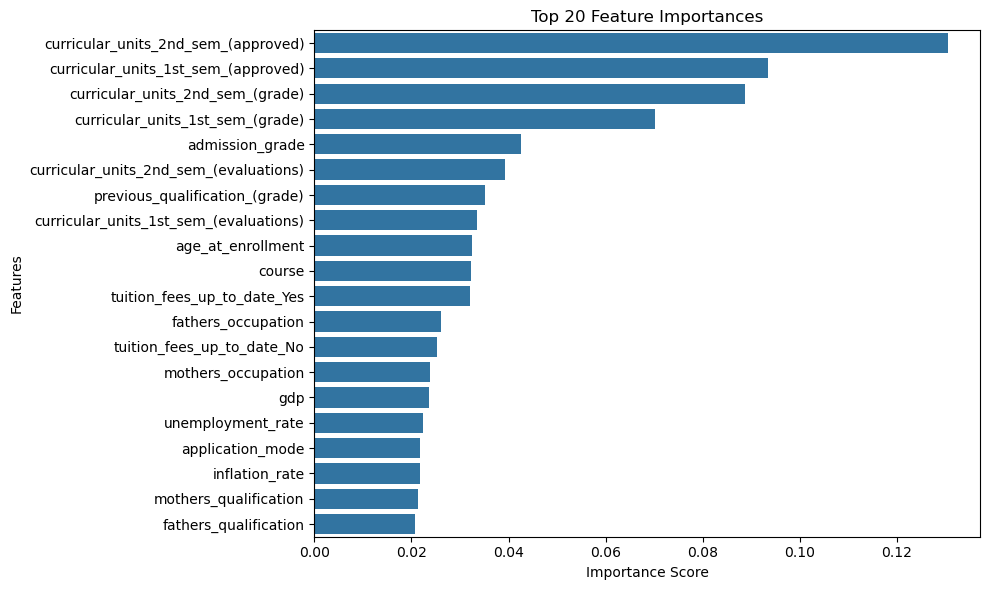



Saving Best Model and Evaluation Metrics...
Model Saved Successfully at: models/RandomForest_pipeline_model.joblib
Evaluation Results Saved to: models/evaluation_results.csv

All Steps Completed. Model Ready for Deployment and Integration.




In [32]:
# Models
models = {
    'LogisticRegression_pipeline': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),

    'RandomForest_pipeline': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),

    'GradientBoosting_pipeline': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
}

# Cross-Validation and Model Training
print("Cross-validating baseline models:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for model_name, pipeline in models.items():
    try:
        scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
        results[model_name] = scores
        print(f"- {model_name}: F1-Weighted = {scores.mean():.4f} ± {scores.std():.4f}")
    except Exception as e:
        print(f"- {model_name}: cross_val_score failed: {e}")
divider()

# Fit Models and Evaluate on Test Set
model_performance = {}
evalRes = {}
for model_name, pipeline in models.items():
    print(f"Training and Evaluating {model_name}:")
    try:
        pipeline.fit(X_train, Y_train)
        model_performance[model_name] = pipeline
        criteria = evaluate_model(pipeline, X_test, Y_test, name=model_name)
        evalRes[model_name] = criteria
    except Exception as e:
        print(f"Failed to train/evaluate {model_name}: {e}")
    divider()

# Hyperparameter Tuning for RandomForest
print("Hyperparameter Tuning for RandomForest_pipeline:")
from sklearn.base import clone
ForPar = clone(models['RandomForest_pipeline'])  # clone to prevent modifying baseline model

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid = GridSearchCV(ForPar, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
try:
    grid.fit(X_train, Y_train)
    print("GridSearch best params:", grid.best_params_)
    print("Best CV score:", grid.best_score_)
    bestPar = grid.best_estimator_

    # Evaluate tuned RandomForest on test set
    tuned = evaluate_model(bestPar, X_test, Y_test, name="RandomForest_Tuned")
    model_performance["RandomForest_Tuned"] = bestPar
    evalRes["RandomForest_Tuned"] = tuned
except Exception as e:
    print("GridSearchCV failed:", e)
divider()

# Selecting Best Model Based on F1-Score (safe selection)
if len(evalRes) == 0:
    raise RuntimeError("No evaluated models available to select from.")

best_model_name = max(evalRes.items(), key=lambda x: x[1].get("F1-Score", -1))[0]
best_model = model_performance[best_model_name]

print(f"Best Model Selected Based on Test F1-Score: {best_model_name}")
divider()

# Feature Importance (only valid for tree-based models)
print("Checking Feature Importances (Applicable only for Tree-Based Models)\n")

# Fetching final feature names after preprocessing
feature_names = get_Ft_Names(preprocessor, catC, NumC)

# If model is pipeline, extract classifier part
clf = best_model.named_steps['classifier'] if isinstance(best_model, Pipeline) else best_model

if hasattr(clf, "feature_importances_"):
    try:
        # Transform training data through preprocessor to align importance array
        X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
        importances = clf.feature_importances_

        # Ensuring dimensional consistency
        if len(importances) == X_train_transformed.shape[1] and len(importances) == len(feature_names):
            plot_feature_importance(feature_names, importances, N=20, save_path="feature_importance.png")
        elif len(importances) == len(feature_names):
            plot_feature_importance(feature_names, importances, N=20, save_path="feature_importance.png")
        else:
            print("Feature importance vector length does not match transformed dataset shape or feature names.\nSkipping feature importance plot.")
    except Exception as e:
        print("Error computing/plotting feature importances:", e)
else:
    print(f"{best_model_name} does not support feature_importances_ (e.g., Logistic Regression). Skipping.")
divider()

# Saving Best Model and Evaluation Results
print("Saving Best Model and Evaluation Metrics...")

OUT_DIR = "models"
os.makedirs(OUT_DIR, exist_ok=True)

final_model_path = os.path.join(OUT_DIR, f"{best_model_name}_model.joblib")
joblib.dump(best_model, final_model_path)
print(f"Model Saved Successfully at: {final_model_path}")

# Save evaluation metrics for reporting
pd.DataFrame(evalRes).T.to_csv(os.path.join(OUT_DIR, "evaluation_results.csv"))
print("Evaluation Results Saved to: models/evaluation_results.csv")

print("\nAll Steps Completed. Model Ready for Deployment and Integration.")
divider()

Cross-validating baseline models:
- LogisticRegression_pipeline: F1-Weighted = 0.7467 ± 0.0122
- RandomForest_pipeline: F1-Weighted = 0.7551 ± 0.0144
- RandomForest_pipeline: F1-Weighted = 0.7551 ± 0.0144
- GradientBoosting_pipeline: F1-Weighted = 0.7607 ± 0.0052


Training and Evaluating LogisticRegression_pipeline:
--- LogisticRegression_pipeline ---
Accuracy  : 0.7638
Precision : 0.7475
Recall    : 0.7638
F1-Score  : 0.7498
ROC-AUC   : 0.8962

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.78       284
           1       0.52      0.35      0.42       159
           2       0.79      0.92      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.76      0.75       885

Confusion Matrix:
 [[214  28  42]
 [ 40  55  64]
 [ 13  22 407]]


Training and Evaluating RandomForest_pipeline:
- GradientBoosting_pipeline: F

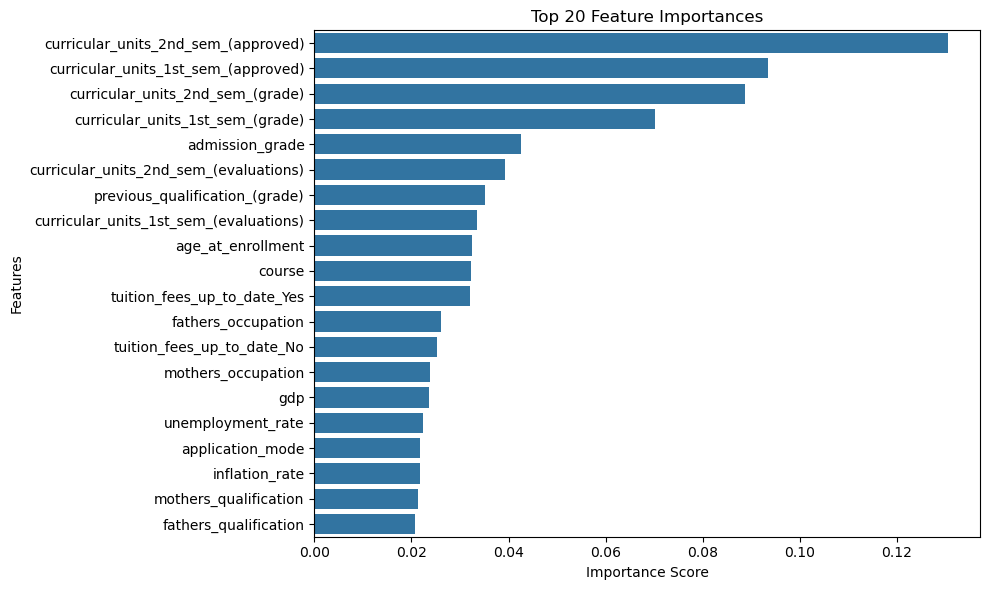

Feature importance plot saved as feature_importance.png


Model Saved & Evaluation Metrics Exported ✅




In [ ]:
# Baseline Model Definitions
models = {
    'LogisticRegression_pipeline': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    # Logistic Regression is suitable for binary/multiclass classification.
    # max_iter=1000 ensures convergence; random_state=42 for reproducibility.

    'RandomForest_pipeline': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    # Random Forest is an ensemble of decision trees for classification/regression.
    # n_estimators=100 specifies the number of trees.

    'GradientBoosting_pipeline': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
    # Gradient Boosting sequentially builds trees to correct errors of previous trees.
}

# Cross-Validation of Baseline Models
print("Cross-validating baseline models:")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# StratifiedKFold preserves class distribution in folds for balanced evaluation.

results = {}
for model_name, pipeline in models.items():
    try:
        scores = cross_val_score(
            pipeline, X_train, Y_train, cv=cv, scoring='f1_weighted', n_jobs=-1
        )
        # f1_weighted accounts for class imbalance in evaluation.
        results[model_name] = scores
        print(f"- {model_name}: F1-Weighted = {scores.mean():.4f} ± {scores.std():.4f}")
    except Exception as e:
        print(f"- {model_name}: Cross-validation failed: {e}")

divider()

# Fit Models and Evaluate on Test Set
model_performance = {}
evalRes = {}

for model_name, pipeline in models.items():
    print(f"Training and evaluating {model_name}:")
    try:
        pipeline.fit(X_train, Y_train)
        model_performance[model_name] = pipeline
        metrics = evaluate_model(pipeline, X_test, Y_test, name=model_name)
        evalRes[model_name] = metrics
    except Exception as e:
        print(f"Failed for {model_name}: {e}")
    divider()
    # divider() separates output for each model evaluation.

# Hyperparameter Tuning for RandomForest
print("Hyperparameter tuning for RandomForest_pipeline:")

from sklearn.base import clone
RF_clone = clone(models['RandomForest_pipeline'])
# clone creates a copy to avoid modifying the original pipeline.

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}
# param_grid defines hyperparameter search space for tuning.

grid = GridSearchCV(
    RF_clone, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1
)
# GridSearchCV tests all parameter combinations with 3-fold CV.
# f1_weighted ensures balanced performance across classes.

grid.fit(X_train, Y_train)
# Fits GridSearchCV on training data to find best parameters.
print("Best Parameters:", grid.best_params_)
print(f"Best CV Score: {grid.best_score_:.4f}")

best_RF_tuned = grid.best_estimator_
# best_estimator_ is the model with the best hyperparameters.
tunedMetrics = evaluate_model(best_RF_tuned, X_test, Y_test, name="RandomForest_Tuned")
# Evaluates tuned RandomForest on test set.
model_performance["RandomForest_Tuned"] = best_RF_tuned
evalRes["RandomForest_Tuned"] = tunedMetrics
divider()

# Select Best Model Based on Test F1-Score
best_model_name = max(evalRes.items(), key=lambda x: x[1]["F1-Score"])[0]
best_model = model_performance[best_model_name]
print(f"Best model selected: {best_model_name}") # Selects model with highest F1-Score on test set.
divider()

# Feature Importance for Tree Models
clf = best_model.named_steps['classifier']
# Extracts classifier from the pipeline for feature importance.

if hasattr(clf, "feature_importances_"):
    print("Plotting feature importances...")
    feature_names = get_Ft_Names(preprocessor, catC, NumC)
    # get_Ft_Names retrieves feature names after preprocessing.
    X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
    importances = clf.feature_importances_

    if len(importances) == len(feature_names):
        plot_feature_importance(feature_names, importances, N=20, save_path="feature_importance.png")
        # Plots top N features and saves as PNG.
        print("Feature importance plot saved as feature_importance.png")
    else:
        print("Mismatch between feature names and importances. Skipping plot.")
else:
    print(f"{best_model_name} is not a tree-based model. Skipping feature importance.")
divider()

# Save Model & Evaluation Metrics
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, f"models/{best_model_name}.joblib")
pd.DataFrame(evalRes).T.to_csv("models/evaluation_results.csv")
print("Model saved and evaluation metrics exported")
divider()

Best Model Selected Based on Test F1-Score: RandomForest_pipeline


Checking Feature Importances (Applicable only for Tree-Based Models)

Feature importance plot saved to feature_importance.png
Feature importance plot saved to feature_importance.png


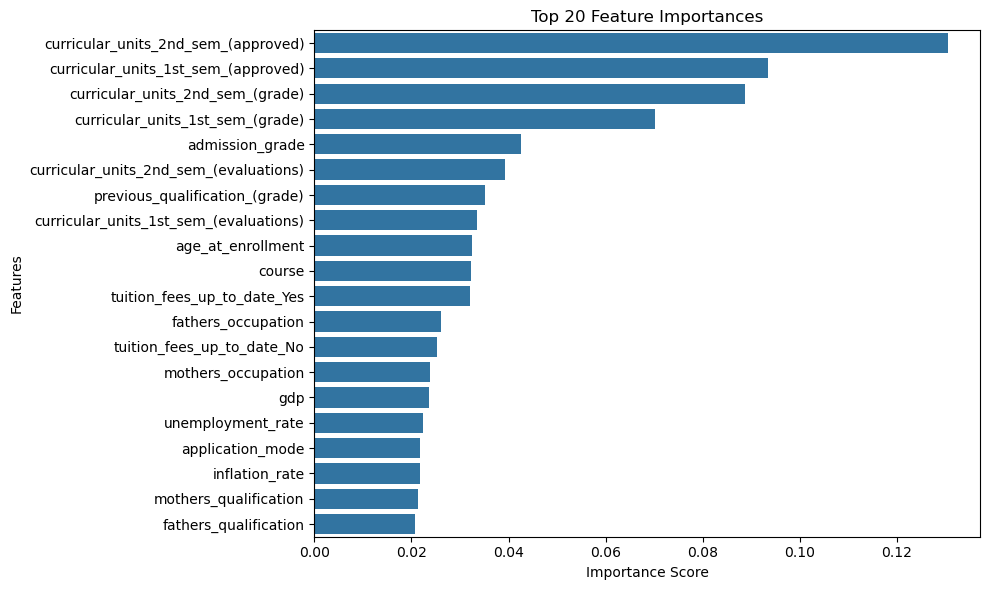



Saving Best Model and Evaluation Metrics...
Model Saved Successfully at: models/RandomForest_pipeline_model.joblib
Evaluation Results Saved to: models/evaluation_results.csv

All Steps Completed. Model Ready for Deployment and Integration.




In [ ]:
# Selecting Best Model Based on F1-Score
best_model_name = max(evalRes.items(), key=lambda x: x[1]["F1-Score"])[0]
best_model = model_performance[best_model_name]

print(f"Best Model Selected Based on Test F1-Score: {best_model_name}")
divider()

# Feature Importance (only valid for tree-based models)
print("Checking Feature Importances (Applicable only for Tree-Based Models)\n")

# Fetching final feature names after preprocessing
feature_names = get_Ft_Names(preprocessor, catC, NumC)

# If model is pipeline, extract classifier part
clf = best_model.named_steps['classifier'] if isinstance(best_model, Pipeline) else best_model

if hasattr(clf, "feature_importances_"):
    # Transform training data through preprocessor to align importance array
    X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train)
    importances = clf.feature_importances_

    # Ensuring dimensional consistency
    if len(importances) == X_train_transformed.shape[1]:
        plot_feature_importance(feature_names, importances, N=20, save_path="feature_importance.png")
    else:
        print("Feature importance vector length does not match transformed dataset shape.\nSkipping feature importance plot.")
else:
    print(f"{best_model_name} does not support feature_importances_ (e.g., Logistic Regression). Skipping.")
divider()

# Saving Best Model and Evaluation Results
print("Saving Best Model and Evaluation Metrics:")

OUT_DIR = "models"
os.makedirs(OUT_DIR, exist_ok=True)

final_model_path = os.path.join(OUT_DIR, f"{best_model_name}_model.joblib")
joblib.dump(best_model, final_model_path)
print(f"Model Saved Successfully at: {final_model_path}")

# Save evaluation metrics for reporting
pd.DataFrame(evalRes).T.to_csv(os.path.join(OUT_DIR, "evaluation_results.csv"))
print("Evaluation Results Saved to: models/evaluation_results.csv")

print("\nAll Steps Completed. Model Ready for Deployment and Integration.")
divider()